In [73]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax.numpy as jnp
import jax
import numpyro
import numpyro.distributions as dist
import cvxpy as cvx
import torch
import matplotlib.pyplot as plt

from cryo_reweighting.examples.gaussian_mixture import GaussianMixture1D

# TODO: import functions from modules, e.g the expectation maximization or other optimization approaches
# TODO: Cruft to be thrown in and uncommented for jax things
#import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
#os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"
##os.environ['CUDA_VISIBLE_DEVICES'] = ''   # To enable CPU backend
#from jax.lib import xla_bridge
#print("Device : ", xla_bridge.get_backend().platform)
## enable 16 bit precision for jax
#from jax import config
#config.update("jax_enable_x64", True)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generate Data

In [74]:
# Parameters for dataset
num_data = 100000
num_nodes = 50
noise_std_dev = 0.5

In [75]:
# Generate noisy data
weights = [0.3, 0.7]
means = [-1.0, 1.0]
std_devs = [0.5, 0.5]
mixture = GaussianMixture1D(weights, means, std_devs)
noiseless_data = np.array(mixture.sample(jax.random.PRNGKey(42), (num_data,)))
data = np.array(noiseless_data + noise_std_dev*jax.random.normal(jax.random.PRNGKey(43), 
                                                        shape=noiseless_data.shape))

# Plot Noiseless and Noisy Data

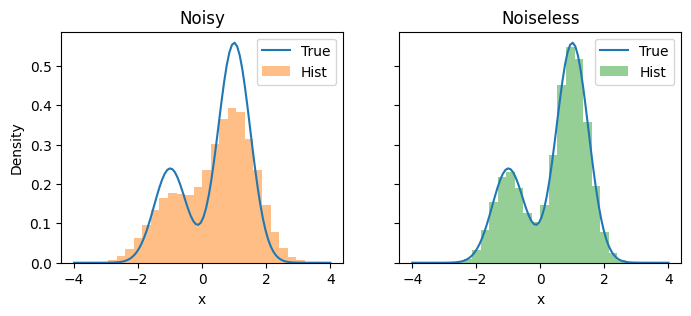

In [76]:
# compute pdf output on a 1d grid
xgrid = jnp.linspace(-4, 4, 100)
dx = xgrid[1] - xgrid[0]
    
# normalize output to integrate to 1 on the grid 
p = np.exp(mixture.log_prob(xgrid))
p /= dx*p.sum() 
    
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)
nbins = 30
for ax in axes:
    ax.plot(xgrid, p, label='True', c='C0')

axes[0].hist(data, bins=nbins, range=(-4, 4), density=True, 
             alpha=0.5, color="C1", label='Hist')
axes[1].hist(noiseless_data, bins=nbins, range=(-4, 4), 
             color="C2", density=True, alpha=0.5, label='Hist')

for ax in axes:
    ax.set_xlabel('x')
    ax.legend()
axes[0].set_title('Noisy')
axes[1].set_title('Noiseless')
axes[0].set_ylabel('Density')
plt.show()



# Estimate Source Distribution

### Choose "nodes"/"structures" and evaluate the log-likelihood

In [77]:
# Choosing nodes: for now, just picking evenly spaced ones
x = np.linspace(-4, 4, num_nodes)

# Choosing initial weights: for now, just constant weights
log_weights_init = np.log(np.ones_like(x)/num_nodes)

# Compute log likelihood matrix
log_Pij = -1*(data[:, np.newaxis] - x[np.newaxis, :])**2 / (2*noise_std_dev**2)

### Throw log-likelihood into method of choice: 
For now, these are in JAX

Two simple examples here (eventually):
1) Expectation Maxmimization on weights for the nodes
2) Whatever convex optmization is used by default in [cvxpy](https://www.cvxpy.org/index.html)

In [78]:
def normalize_weights(log_weights):
    """
    Gets the input vector log weights to sum to 1 when exponentionated, and returns exponentiated vector
    """
    weighted_alphas = jnp.exp(log_weights)
    weighted_alphas = weighted_alphas / jnp.sum(weighted_alphas)
    return weighted_alphas

def expectation_maximization_weights(log_Pij, log_weights_init=None, num_iterations=1000):
    """
    This function updates the weights according to the expectation maximization
     algorithm for mixture models.
    """

    num_data, num_nodes = log_Pij.shape
    if log_weights_init is None:
        log_weights = jnp.zeros((1, num_nodes))
    else:
        log_weights = log_weights_init
    log_weights = jnp.log(normalize_weights(log_weights))

    norms = np.zeros(num_iterations)
    loss = np.zeros(num_iterations)
    for k in range(num_iterations):
        log_likelihood_per_image = jax.scipy.special.logsumexp(log_Pij + log_weights, axis=1)
        log_weighted_likelihoods = log_Pij + log_weights
        log_posteriors = log_weighted_likelihoods - log_likelihood_per_image.reshape(num_data, 1)
        log_weights = jax.scipy.special.logsumexp(log_posteriors - jnp.log(num_data), axis=0)
        
        # compute two parameters to monitor for convergence: norm of weights, and log marginal likelihood
        norms[k] = jnp.linalg.norm(normalize_weights(log_weights))
        loss[k] = -1*(1/num_nodes)*jnp.sum(log_likelihood_per_image) 

    # Normalize weights and return log weights
    log_weights = jnp.log(normalize_weights(log_weights))
    return log_weights, norms, loss

# NOTE: this one just doesn't work right now, likely due to that it uses an exponential of the log_Pij(?)
def solve_cvx_weights(log_Pij, log_weights_init=None):
    import cvxpy as cvx
    """
    Code almost directly from https://github.com/jake-soloff/NPEB/blob/master/npeb/GLMixture.py
    """
    num_data, num_nodes = log_Pij.shape

    # Normalize rows of log_Pij for stability
    log_Pij -= np.amax(log_Pij, 1)[:, np.newaxis]
    Pij = np.exp(log_Pij)
    
    w = cvx.Variable(num_nodes)
    constraints = [w >= 0, cvx.sum(w) == 1]
    obj = cvx.Maximize(cvx.sum(cvx.log(Pij @ w)))
    prob = cvx.Problem(obj, constraints)
    print("using default solver in cvxpy for now, with full outputs of optimization")
    prob.solve(verbose=True)
    print(w.value)
    log_weights = jnp.log(w.value)
    return log_weights



Text(0.5, 0, 'Iteration')

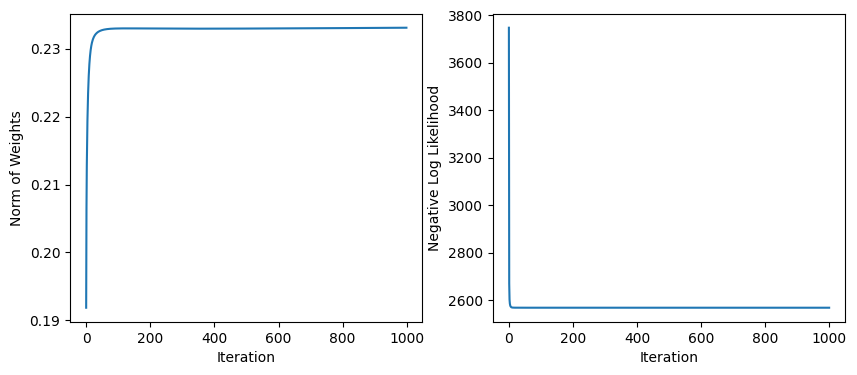

In [79]:
# solve with expectation maximization (em)
num_iterations = 1000
em_log_weights, norms, loss = expectation_maximization_weights(log_Pij, log_weights_init=log_weights_init, num_iterations=num_iterations)
em_weights = normalize_weights(em_log_weights)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
axes[0].plot(norms)
axes[0].set_ylabel("Norm of Weights")
axes[0].set_xlabel("Iteration")

axes[1].plot(loss)
axes[1].set_ylabel("Negative Log Likelihood")
axes[1].set_xlabel("Iteration")

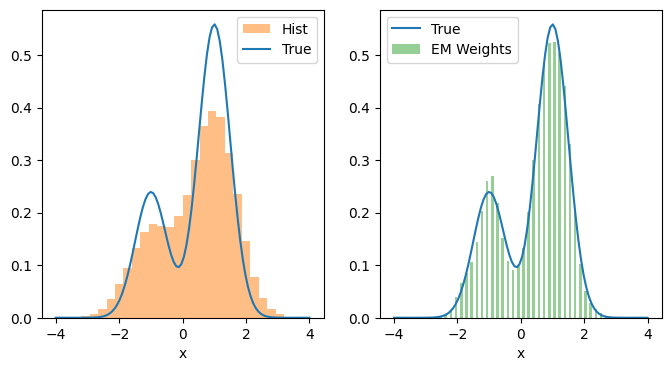

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True)
axes[0].hist(data, bins=nbins, range=(-4, 4), density=True, 
             alpha=0.5, color="C1", label='Hist')

axes[1].bar(x, em_weights/(x[1] - x[0]), 
    width=dx, label='EM Weights', color="C2", alpha=0.5)

for ax in axes:
    ax.plot(xgrid, p, label='True', c='C0')
    ax.set_xlabel('x')
    ax.legend()
plt.legend()